<a href="https://colab.research.google.com/github/yassine-grati/Assistant-de-recherche-avec-Gemini-LangChain-and-Chroma/blob/main/Copie_de_IBI2025_RAG_LangGraph.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Amélioration des résultats avec LangGraph

Ce notebook présente une amélioration du système RAG développé précédemment. Construit à l'aide de LangGraph, ce système est conçu pour répondre aux questions en utilisant des documents sources et intègre des étapes pour améliorer la robustesse, comme la réécriture de requête et la vérification de la pertinence des sources.

## Installation des packages nécessaires

In [ ]:
!pip install -U -q langchain-community
!pip install -q langchain-google-genai
!pip install -q chromadb
!pip install -q pypdf
!pip install -q langgraph

## Import des packages nécessaires

In [ ]:
from langchain_google_genai import GoogleGenerativeAIEmbeddings
import os
from langchain.text_splitter import RecursiveCharacterTextSplitter
import getpass
from langchain import PromptTemplate
from langchain import hub
from langchain.docstore.document import Document
from langchain.document_loaders import WebBaseLoader
from langchain.schema import StrOutputParser
from langchain.schema.prompt_template import format_document
from langchain.schema.runnable import RunnablePassthrough
from langchain.vectorstores import Chroma
from langchain_google_genai import ChatGoogleGenerativeAI
from langchain_community.document_loaders import PyPDFLoader
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.pydantic_v1 import BaseModel, Field
from typing import List
from typing_extensions import TypedDict
from langgraph.graph import END, StateGraph

/usr/local/lib/python3.11/dist-packages/IPython/core/interactiveshell.py:3553: LangChainDeprecationWarning: As of langchain-core 0.3.0, LangChain uses pydantic v2 internally. The langchain_core.pydantic_v1 module was a compatibility shim for pydantic v1, and should no longer be used. Please update the code to import from Pydantic directly.

For example, replace imports like: `from langchain_core.pydantic_v1 import BaseModel`
with: `from pydantic import BaseModel`
or the v1 compatibility namespace if you are working in a code base that has not been fully upgraded to pydantic 2 yet. 	from pydantic.v1 import BaseModel

  exec(code_obj, self.user_global_ns, self.user_ns)


## Définition du modèle LLM et du modèle embedding

In [ ]:
os.environ['GOOGLE_API_KEY'] = "XXXXXXXXXXXX" # Ici remplacez par votre API Key !!!
gemini_embeddings = GoogleGenerativeAIEmbeddings(model="models/embedding-001")
llm = ChatGoogleGenerativeAI(model="gemini-1.5-flash", temperature=0.7, top_p=0.85)

## Chargement des documents sources

In [ ]:
def load_file(file_path):
    loader = PyPDFLoader(file_path)
    pages = loader.load()
    return pages

def generate_vectorstore(file_path):
    pages = load_file(file_path)

    text_splitter = RecursiveCharacterTextSplitter(
        chunk_size=1000,
        chunk_overlap=200
    )

    chunked_documents = text_splitter.split_documents(pages)

    print(f"Chargé {len(pages)} pages et créé {len(chunked_documents)} chunks.")

    vectorstore = Chroma.from_documents(
                        documents=chunked_documents,
                        embedding=gemini_embeddings,
                        persist_directory="./chroma_db"
                    )

    print(f"Base de données vectorielle créée/mise à jour dans ./chroma_db avec {len(chunked_documents)} chunks.")


In [ ]:
generate_vectorstore(r"ici il faut remplacer par le path de votre fichier .pdf")

Chargé 599 pages et créé 992 chunks.
Base de données vectorielle créée/mise à jour dans ./chroma_db avec 992 chunks.


## Retrieve :
Cette étape permet de récupérer les documents pertinents à partir de la base de données vectorielle en utilisant la question actuelle.

In [ ]:
def get_retriver(state):

    print("---PHASE DE RECHERCHE DANS LA BD---")
    question = state["question"]

    # Retrieval
    vectorstore_disk = Chroma(
                         persist_directory="./chroma_db",
                         embedding_function=gemini_embeddings
                       )
    retriever = vectorstore_disk.as_retriever(search_kwargs={"k": 3})
    documents = retriever.get_relevant_documents(question)

    return {"documents": documents, "question": question}

## Grade Documents :
Évalue la pertinence des documents récupérés par rapport à la question.

In [ ]:
class GradeDocuments(BaseModel):

    binary_score: str = Field(
        description="Documents are relevant to the question, 'yes' or 'no'"
    )

def get_doc_grader():

    str_grade_prompt = """You are an expert grader assessing relevance of a retrieved document to a user question.
                Follow these instructions for grading:
                  - If the document contains keyword(s) or semantic meaning related to the question, grade it as relevant.
                  - Your grade should be either 'yes' or 'no' to indicate whether the document is relevant to the question or not.
             """
    grade_prompt = ChatPromptTemplate.from_messages(
        [
            ("system", str_grade_prompt),
            ("human", """Retrieved document:
                        {document}

                        User question:
                        {question}
                      """),
        ]
    )
    structured_llm_grader = llm.with_structured_output(GradeDocuments)
    doc_grader = (grade_prompt
                  |
              structured_llm_grader)

    return doc_grader

### Test du doc_grader

In [ ]:
query = "what are the challenges of generative ai"
retrievement = get_retriver({"question": query})
top3_docs = retrievement['documents']
for doc in top3_docs:
    #print(doc.page_content)
    print('GRADE:', get_doc_grader().invoke({"question": query, "document": doc.page_content}))
    print()

---PHASE DE RECHERCHE DANS LA BD---


<ipython-input-6-c9651c9e33ec>:7: LangChainDeprecationWarning: The class `Chroma` was deprecated in LangChain 0.2.9 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-chroma package and should be used instead. To use it run `pip install -U :class:`~langchain-chroma` and import as `from :class:`~langchain_chroma import Chroma``.
  vectorstore_disk = Chroma(
<ipython-input-6-c9651c9e33ec>:12: LangChainDeprecationWarning: The method `BaseRetriever.get_relevant_documents` was deprecated in langchain-core 0.1.46 and will be removed in 1.0. Use :meth:`~invoke` instead.
  documents = retriever.get_relevant_documents(question)


GRADE: binary_score='yes'

GRADE: binary_score='yes'

GRADE: binary_score='yes'

GRADE: binary_score='yes'

GRADE: binary_score='yes'



### Règle d'évaluation des sources :
Si au moins une source est jugée pertinente, nous considérons que la phase de recherche a été réussie et nous passons à l'étape suivante.

In [ ]:
def grade_documents(state):

    print("---EVALUATION DE LA PERTINENCE DES SOURCES---")
    question = state["question"]
    documents = state["documents"]

    # Score each doc
    filtered_docs = []
    new_retrievement_needed = "No"
    if documents:
        for d in documents:
            score = get_doc_grader().invoke(
                {"question": question, "document": d.page_content}
            )
            grade = score.binary_score
            if grade == "yes":
                print("---EVALUATION: SOURCE PERTINENTE---")
                filtered_docs.append(d)

    if len(filtered_docs)==0:
        print("---PAS DE SOURCES TROUVEES---")
        new_retrievement_needed = "Yes"

    return {"documents": filtered_docs, "question": question, "new_retrievement_needed": new_retrievement_needed}

## Reformulation de la question :

Reformule la question originale pour tenter d'améliorer la récupération lors d'une nouvelle tentative.

In [ ]:
def get_rewritten_question(state):

    question = state["question"]
    str_rewrite_prompt = """Act as a question re-writer and perform the following task:
                 - Convert the following input question to a better version that is optimized for chrome retriever.
                 - When re-writing, look at the input question and try to reason about the underlying semantic intent / meaning.
                 - Propose only one version of the rewritten question.
             """
    re_write_prompt = ChatPromptTemplate.from_messages(
        [
            ("system", str_rewrite_prompt),
            ("human", """Here is the initial question:
                        {question}

                        Formulate an improved question.
                      """,
            ),
        ]
    )

    question_rewriter = (re_write_prompt | llm | StrOutputParser())

    better_question = question_rewriter.invoke(question)

    return {"question": better_question, "rewriten_question": 1}

## Test de la reformulation

In [ ]:
query = "what about genai"
rewrite_result = get_rewritten_question({"question": query})
rewrite_result

{'question': 'What is GenAI?', 'rewriten_question': 1}

## Génération de la réponse :

Génère une réponse à la question en utilisant les documents pertinents comme contexte.

In [ ]:
def get_answer_prompt():
    llm_prompt_template = """You are an assistant for question-answering tasks.
    Use the following context to answer the question.
    If you don't know the answer, just say that you don't know.
    Use five sentences maximum and keep the answer concise.\n
    Question: {question} \nContext: {context} \nAnswer:"""

    return PromptTemplate.from_template(llm_prompt_template)

def format_docs(docs):
    return "\n\n".join(doc.page_content for doc in docs)

def get_llm_response(state):

    question = state["question"]
    llm_prompt = get_answer_prompt()
    rag_chain = (
        {
            "context": lambda state: format_docs(state["documents"]),
            "question": lambda state: state["question"],
        }
        | llm_prompt
        | llm
        | StrOutputParser()
    )

    return {"generation": rag_chain.invoke(state)}


## No Document Found Node :

Gère le cas où aucun document pertinent n'a pu être trouvé après la réécriture de la requête, en définissant un message final.

In [ ]:
def no_relevent_docs(state):

    return {"generation": "No relevent docs found !"}

### Décision

Décide si les documents sont suffisamment pertinents pour générer une réponse. Si non et que la requête n'a pas encore été réécrite, passe à la reformulation de la question. Si non et que la requête a déjà été réécrite, passe à no_document_found. Si oui, passe à generate_answer.

In [ ]:
def decide_to_generate(state):

    print("---DECISION SUR LA PROCHAINE ETAPE---")
    new_retrievement_needed = state["new_retrievement_needed"]
    rewriten_question = state["rewriten_question"]

    if rewriten_question==1 and new_retrievement_needed == "Yes":
      print("---DECISION: PAS DE SOURCE PERTINENTE---")
      return "no_relevent_docs"
    elif new_retrievement_needed == "Yes":
        # All documents have been filtered check_relevance
        # We will re-generate a new query
        print("---DECISION: REFORMULATION DE LA DECISION---")
        return "rewrite_query"
    else:
        # We have relevant documents, so generate answer
        print("---DECISION: GENERATION DE LA REPONSE---")
        return "generate_answer"

## Définition du graphe

In [ ]:
class GraphState(TypedDict):

    question: str
    generation: str
    new_retrievement_needed: str
    rewriten_question: int
    documents: List[str]


rag_graph= StateGraph(GraphState)

rag_graph.add_node("retrieve", get_retriver)  # Node de rechcerche
rag_graph.add_node("grade_documents", grade_documents)  # Node d'évaluation de la pertinence des ressources
rag_graph.add_node("rewrite_query", get_rewritten_question)  # Node de re-ecriture de la question
rag_graph.add_node("generate_answer", get_llm_response)  # Node génération de la question
rag_graph.add_node("no_relevent_docs", no_relevent_docs)  # Node à déclencher dans le cas ou aucune source pertinente n'est trouvée

# Construction du graphe
rag_graph.set_entry_point("retrieve")
rag_graph.add_edge("retrieve", "grade_documents")
rag_graph.add_conditional_edges(
    "grade_documents",
    decide_to_generate,
    {"rewrite_query": "rewrite_query", "generate_answer": "generate_answer", "no_relevent_docs": "no_relevent_docs"},
)
rag_graph.add_edge("rewrite_query", "retrieve")
rag_graph.add_edge("generate_answer", END)
rag_graph.add_edge("no_relevent_docs", END)

# Compilation
rag_graph = rag_graph.compile()

## Affichage du graphe :

Cette partie est facultative et consiste à afficher le graphique pour une visualisation graphique des différentes étapes du processus.

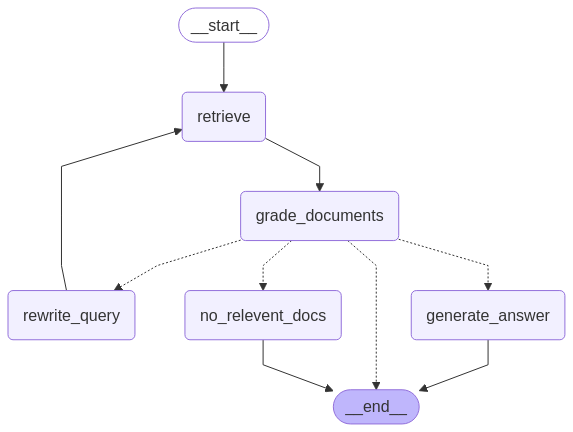

In [ ]:
from IPython.display import Image, display, Markdown

display(Image(rag_graph.get_graph().draw_mermaid_png()))

## Test du processus

In [ ]:
query = "the capital of tunisia" #"Define generative ai"
response = rag_graph.invoke({"question": query, "rewriten_question": 0})

---PHASE DE RECHERCHE DANS LA BD---
---EVALUATION DE LA PERTINENCE DES SOURCES---
---PAS DE SOURCES TROUVEES---
---DECISION SUR LA PROCHAINE ETAPE---
---DECISION: REFORMULATION DE LA DECISION---
---PHASE DE RECHERCHE DANS LA BD---
---EVALUATION DE LA PERTINENCE DES SOURCES---
---PAS DE SOURCES TROUVEES---
---DECISION SUR LA PROCHAINE ETAPE---
---DECISION: PAS DE SOURCE PERTINENTE---


## Afficher les résultats

### Affichage de la réponse générer par le système RAG

In [ ]:
response['generation']

'No relevent docs found !'

### Affichage de tout l'objet 'response'

In [ ]:
response

{'question': 'What is the capital city of Tunisia?',
 'generation': 'No relevent docs found !',
 'new_retrievement_needed': 'Yes',
 'rewriten_question': 1,
 'documents': []}